# DrugBank

In [1]:
import os
import numpy as np
import pandas as pd
import zipfile
import untangle
import requests
import collections

from urllib.request import urlretrieve
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = "AZ project/full database.xml"

# Extracting Data from Drugbank (Dhimmel method)

In [47]:
# https://github.com/ManzoorElahi/Drugbank-Classification/blob/master/Scripts/dhimmel%20-%20drugbank.ipynb

In [48]:
with open(filename) as xml_file:  
    tree = ET.parse(xml_file)
root = tree.getroot()

In [49]:
ns = '{http://www.drugbank.ca}'
inchikey_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChIKey']/{ns}value"
inchi_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChI']/{ns}value"
SMILES_template = "{ns}calculated-properties/{ns}property[{ns}kind='SMILES']/{ns}value"
logS_template = "{ns}experimental-property/{ns}property[{ns}kind='logS']/{ns}value"
logP_template = "{ns}experimental-property/{ns}property[{ns}kind='logP']/{ns}value"
Water_Solubility_template = "{ns}experimental-property/{ns}property[{ns}kind='Water Solubility']/{ns}value"
Melting_Point_template = "{ns}experimental-property/{ns}property[{ns}kind='Melting Point']/{ns}value"
Boiling_Point_template = "{ns}experimental-property/{ns}property[{ns}kind='Boiling Point']/{ns}value"
Hydrophobicity_template = "{ns}experimental-property/{ns}property[{ns}kind='Hydrophobicity']/{ns}value"
Isoelectric_Point_template = "{ns}experimental-property/{ns}property[{ns}kind='Isoelectric Point']/{ns}value"
caco2_Permeability_template = "{ns}experimental-property/{ns}property[{ns}kind='caco2 Permeability']/{ns}value"
pKa_template = "{ns}experimental-property/{ns}property[{ns}kind='pKa']/{ns}value"
Radioactivity_template = "{ns}experimental-property/{ns}property[{ns}kind='Radioactivity']/{ns}value"

    
rows = list()
for i, drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['description'] = drug.findtext(ns + "description")
    row['pharmacodynamics'] = drug.findtext(ns + "pharmacodynamics")
    row['mechanism-of-action'] = drug.findtext(ns + "mechanism-of-action")
    row['toxicity'] = drug.findtext(ns + "toxicity")
    row['metabolism'] = drug.findtext(ns + "metabolism")
    row['absorption'] = drug.findtext(ns + "absorption")
    row['volume-of-distribution'] = drug.findtext(ns + "volume-of-distribution")
    row['half-life'] = drug.findtext(ns + "half-life")
    row['protein-binding'] = drug.findtext(ns + "protein-binding")
    row['route-of-elimination'] = drug.findtext(ns + "route-of-elimination")
    row['clearance'] = drug.findtext(ns + "clearance")

    row['groups'] = [group.text for group in
        drug.findall("{ns}groups/{ns}group".format(ns = ns))]
    row['targets'] = [target.text for target in
        drug.findall("{ns}targets/{ns}target".format(ns = ns))]
    row['enzymes'] = [enzyme.text for enzyme in
        drug.findall("{ns}enzymes/{ns}enzyme".format(ns = ns))]
    
    
    row['atc_codes'] = [code.get('code') for code in
        drug.findall("{ns}atc-codes/{ns}atc-code".format(ns = ns))]
    row['categories'] = [x.findtext(ns + 'category') for x in
        drug.findall("{ns}categories/{ns}category".format(ns = ns))]
    row['inchi'] = drug.findtext(inchi_template.format(ns = ns))
    row['inchikey'] = drug.findtext(inchikey_template.format(ns = ns))
    row['SMILES'] = drug.findtext(SMILES_template.format(ns = ns))
    row['logS'] = drug.findtext(logS_template.format(ns = ns))
    row['logP'] = drug.findtext(logP_template.format(ns = ns))
    row['Water_Solubility'] = drug.findtext(Water_Solubility_template.format(ns = ns))
    row['Melting_Point'] = drug.findtext(Melting_Point_template.format(ns = ns))
    row['Boiling_Point'] = drug.findtext(Boiling_Point_template.format(ns = ns))
    row['Hydrophobicity'] = drug.findtext(Hydrophobicity_template.format(ns = ns))
    row['Isoelectric_Point'] = drug.findtext(Isoelectric_Point_template.format(ns = ns))
    row['caco2_Permeability'] = drug.findtext(caco2_Permeability_template.format(ns = ns))
    row['pKa'] = drug.findtext(pKa_template.format(ns = ns))
    row['Radioactivity'] = drug.findtext(Radioactivity_template.format(ns = ns))
    
    
    # Add drug aliases
    aliases = {
        elem.text for elem in 
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}synonyms/{ns}synonym[@language='English']".format(ns = ns)) +
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}products/{ns}product/{ns}name".format(ns = ns))

    }
    aliases.add(row['name'])
    row['aliases'] = sorted(aliases)

    rows.append(row)

In [50]:
def collapse_list_values(row):
    for key, value in row.items():
        if isinstance(value, list):
            row[key] = '|'.join(value)
    return row

rows = list(map(collapse_list_values, rows))

In [51]:
#columns = ['drugbank_id', 'name', 'type', 'groups', 'atc_codes', 'categories', 
#           'inchikey', 'inchi', 'description', 'SMILES', 'logP', 'logS', 
#           'Water_Solubility']
df_db = pd.DataFrame.from_dict(rows)#[columns]
df_db

,type,drugbank_id,name,description,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,volume-of-distribution,...,logP,Water_Solubility,Melting_Point,Boiling_Point,Hydrophobicity,Isoelectric_Point,caco2_Permeability,pKa,Radioactivity,aliases
0,biotech,DB00001,Lepirudin,Lepirudin is a recombinant hirudin formed by 6...,Lepirudin is a recombinant hirudin that acts a...,Lepirudin is a direct thrombin inhibitor used ...,The acute toxicity of intravenous lepirudin wa...,"As a polypeptide, lepirudin is expected to be ...",Lepirudin administered as a single intravenous...,The volume of distribution of lepirudin at ste...,...,None,None,None,None,None,None,None,None,None,Lepirudin|Refludan
1,biotech,DB00002,Cetuximab,Cetuximab is a recombinant chimeric human/mous...,Cetuximab is an anticancer agent that works by...,The epidermal growth factor receptor (EGFR) is...,The intravenous LD<sub>50</sub> is > 300 mg/kg...,"Like other monoclonal antibodies, cetuximab is...",After administration of a 400 mg/m<sup>2</sup>...,The volume of the distribution is about 2-3 L/...,...,None,None,None,None,None,None,None,None,None,Cetuximab|Erbitux
2,biotech,DB00003,Dornase alfa,Dornase alfa is a biosynthetic form of human d...,Cystic fibrosis (CF) is a disease characterize...,Dornase alfa is a biosynthetic form of human D...,Adverse reactions occur at a frequency of < 1/...,While no conclusive studies have yet been publ...,Studies in rats and monkeys after inhalation o...,"In studies in rats and monkeys, the initial vo...",...,None,None,None,None,None,None,None,None,None,\n |Dornase alfa|Pulmozyme|Pulmozyme 1mg/ml
3,biotech,DB00004,Denileukin diftitox,A recombinant DNA-derived cytotoxic protein co...,Denileukin diftitox (Ontak) directs the cytoci...,Denileukin diftitox binds to the high-affinity...,,,,* 0.06 to 0.09 L/kg,...,None,None,None,None,None,None,None,None,None,Denileukin diftitox|Ontak
4,biotech,DB00005,Etanercept,Dimeric fusion protein consisting of the extra...,Etanercept binds specifically to tumor necrosi...,There are two distinct receptors for TNF (TNFR...,,"As etanercept is a fusion protein antibody, it...",Population pharmacokinetic modeling in adults ...,Population pharmacokinetic modeling predicts a...,...,None,None,None,None,None,None,None,None,None,\n |Benepali|Brenzys|Enbrel|Erelzi|Etaner...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15230,small molecule,DB17382,AUM-601,AUM-601 is a highly selective pan-TRK(tropomyo...,,,,,,,...,None,None,None,None,None,None,None,None,None,AUM-601
15231,small molecule,DB17383,FN-1501,,,,,,,,...,None,None,None,None,None,None,None,None,None,FN-1501
15232,small molecule,DB17384,Tinengotinib,,,,,,,,...,None,None,None,None,None,None,None,None,None,Tinengotinib
15233,small molecule,DB17385,Lipotecan,,,,,,,,...,None,None,None,None,None,None,None,None,None,Lipotecan


In [52]:
# select small molecules and drop rows with no SMILE strings
df_db = df_db[df_db['type'] == 'small molecule']
df_db = df_db.dropna(subset = ['SMILES']).reset_index().drop(columns = 'index')

In [9]:
# col description and categories are important
df_db.columns

Index(['type', 'drugbank_id', 'name', 'description', 'pharmacodynamics',
       'mechanism-of-action', 'toxicity', 'metabolism', 'absorption',
       'volume-of-distribution', 'half-life', 'protein-binding',
       'route-of-elimination', 'clearance', 'groups', 'targets', 'enzymes',
       'atc_codes', 'categories', 'inchi', 'inchikey', 'SMILES', 'logS',
       'logP', 'Water_Solubility', 'Melting_Point', 'Boiling_Point',
       'Hydrophobicity', 'Isoelectric_Point', 'caco2_Permeability', 'pKa',
       'Radioactivity', 'aliases'],
      dtype='object')

In [10]:
df_db[df_db['categories'].str.contains('Immunosuppressive') &
     df_db['type'].str.contains('small molecule')]

,type,drugbank_id,name,description,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,volume-of-distribution,...,logP,Water_Solubility,Melting_Point,Boiling_Point,Hydrophobicity,Isoelectric_Point,caco2_Permeability,pKa,Radioactivity,aliases
8,small molecule,DB00091,Cyclosporine,Cyclosporine is a calcineurin inhibitor known ...,Cyclosporine exerts potent immunosuppressive a...,Cyclosporine is a calcineurin inhibitor that i...,The oral LD50 in rats is 1480 mg/kg and the TD...,Cyclosporine is metabolized in the intestine a...,The absorption of cyclosporine occurs mainly i...,The distribution of cyclosporine in the blood ...,...,None,None,None,None,None,None,None,None,None,\n |Apo-cyclosporine Oral Solution|Aqua-s...
16,small molecule,DB00120,Phenylalanine,Phenylalanine is an essential aromatic amino a...,"Used by the brain to produce Norepinephrine, a...",The supposed antidepressant effects of L-pheny...,L-phenylalanine will exacerbate symptoms of ph...,Hepatic. L-phenylalanine that is not metaboliz...,Absorbed from the small intestine by a sodium ...,,...,None,None,None,None,None,None,None,None,None,2.5% Travasol Amino Acid Injection With Electr...
74,small molecule,DB00180,Flunisolide,"Flunisolide (marketed as AeroBid, Nasalide, Na...",Flunisolide is a synthetic corticosteroid. It ...,Flunisolide is a glucocorticoid receptor agoni...,,"Primarily hepatic, converted to the S beta-OH ...",Absorbed rapidly,,...,None,None,None,None,None,None,None,None,None,\n |Aerobid|Aerobid-M|Aerospan|Apo-flunis...
82,small molecule,DB00188,Bortezomib,Bortezomib is a dipeptide boronic acid derivat...,Bortezomib works to target the ubiquitin-prote...,The ubiquitin-proteasome pathway is a homeosta...,The Lowest published toxic dose (TD<sub>Lo</su...,"Bortezomib is primarily metabolized by CYP3A4,...",Following intravenous administration of 1 mg/m...,The mean distribution volume of bortezomib ran...,...,None,None,None,None,None,None,None,None,None,Bortezomib|Bortezomib Accord|Bortezomib Fresen...
116,small molecule,DB00222,Glimepiride,"First introduced in 1995, glimepiride is a mem...",Glimepiride stimulates the secretion of insuli...,ATP-sensitive potassium channels on pancreatic...,The oral LD50 value in rats is > 10000 mg/kg.[...,Glimepiride is reported to undergo hepatic met...,Glimepiride is completely absorbed after oral ...,Following intravenous dosing in healthy subjec...,...,None,None,None,None,None,None,None,None,None,\n |Amaryl|Apo-glimepiride|Avaglim|Avanda...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11064,small molecule,DB16123,Ceralifimod,Ceralifimod is under investigation in clinical...,,,,,,,...,None,None,None,None,None,None,None,None,None,Ceralifimod
11263,small molecule,DB16650,Deucravacitinib,Deucravacitinib is a novel oral selective tyro...,Deucravacitinib is a tyrosine kinase 2 (TYK2) ...,Tyrosine kinase 2 (TYK2) is a member of the Ja...,No information regarding the acute toxicity pr...,Deucravacitinib undergoes N-demethylation medi...,"Following oral administration, deucravacitinib...",The volume of distribution of deucravacitinib ...,...,None,None,None,None,None,None,None,None,None,Deucravacitinib|Sotyktu
11275,small molecule,DB16703,Belumosudil,Belumosudil is used in the treatment of chroni...,Belumosudil appears to inhibit several pro-fib...,Chronic graft-versus-host disease (GVHD) is a ...,There are no data regarding overdosage with be...,The _in vitro_ metabolism of belumosudil occur...,"Following oral administration, the mean bioava...",Following a single oral dose of belumosudil in...,...,None,None,None,None,None,None,None,None,None,\n |Belumosudil|Rezurock
11348,small molecule,DB16861,Azodicarbonamide,,,,,,,,...,None,None,None,None,None,None,None,None,None,Azodicarbonamide


In [11]:
# df_i -> small molecules categorised as immunosuppressive agent in drugbank
df_i = df_db[df_db['categories'].str.contains('Immunosuppressive') &
     df_db['type'].str.contains('small molecule')].copy().reset_index().drop(columns = 'index')

# df_ni -> non-immunosuppresive agents
df_ni = df_db[~df_db['drugbank_id'].isin(df_i['drugbank_id'])].copy().reset_index().drop(columns = 'index')

print(df_db.shape, df_ni.shape, df_i.shape)

(11583, 33) (11360, 33) (223, 33)


In [24]:
df_db

,type,drugbank_id,name,description,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,volume-of-distribution,...,logP,Water_Solubility,Melting_Point,Boiling_Point,Hydrophobicity,Isoelectric_Point,caco2_Permeability,pKa,Radioactivity,aliases
0,small molecule,DB00006,Bivalirudin,Bivalirudin is a synthetic 20 residue peptide ...,Bivalirudin mediates an inhibitory action on t...,Inhibits the action of thrombin by binding bot...,"Based on a study by Gleason et al., the no-obs...",80% proteolytic cleavage,"Following intravenous administration, bivaliru...",0.2L/kg,...,None,None,None,None,None,None,None,None,None,\n |Angiomax|Angiomax RTU|Angiox|Bivaliru...
1,small molecule,DB00007,Leuprolide,Leuprolide is a synthetic 9-residue peptide an...,Leuprolide is a gonadotropin-releasing hormone...,Gonadotropin-releasing hormone (GnRH) is a nat...,"Leuprolide is considered extremely safe, with ...",Radiolabeling studies suggest that leuprolide ...,Leuprolide is typically administered as a sing...,Leuprolide has an apparent steady-state volume...,...,None,None,None,None,None,None,None,None,None,\n |Camcevi|Eligard|Fensolvi|Leuprolide|L...
2,small molecule,DB00014,Goserelin,"Goserelin is a synthetic hormone. In men, it s...",The pharmacokinetics of goserelin have been de...,Goserelin is a synthetic decapeptide analogue ...,No experience of overdosage from clinical trials.,Hepatic,"Inactive orally, rapidly absorbed following su...",* 44.1 ± 13.6 L [subcutaneous administration o...,...,None,None,None,None,None,None,None,None,None,Goserelin|Zoladex|Zoladex LA
3,small molecule,DB00027,Gramicidin D,Gramcidin D is a heterogeneous mixture of thre...,Gramicidin is particularly effective against g...,Gramicidin D binds to and inserts itself into ...,,,,,...,None,None,None,None,None,None,None,None,None,\n |Antibiotic Cream|Antibiotic Cream Plu...
4,small molecule,DB00035,Desmopressin,"Desmopressin (dDAVP), a synthetic analogue of ...","By mimicking the actions of endogenous ADH, de...",Upon binding of desmopressin to V2 receptors i...,Intravenous TDLo in humans is reported to be 0...,"In vitro, in human liver microsome preparation...",Following nasal spray administration of 0.83 m...,The distribution volume of orally administered...,...,None,None,None,None,None,None,None,None,None,\n |Apo-desmopressin|Bipazen|DDAVP Rhinal...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11578,small molecule,DB17379,(-)-Gossypol,"(-)-Gossypol or (R)-Gossypol, is the R-isomer ...",,,,,,,...,None,None,None,None,None,None,None,None,None,(-)-Gossypol
11579,small molecule,DB17383,FN-1501,,,,,,,,...,None,None,None,None,None,None,None,None,None,FN-1501
11580,small molecule,DB17384,Tinengotinib,,,,,,,,...,None,None,None,None,None,None,None,None,None,Tinengotinib
11581,small molecule,DB17385,Lipotecan,,,,,,,,...,None,None,None,None,None,None,None,None,None,Lipotecan


In [12]:
df_i[df_i['toxicity'].str.contains('LD')]

,type,drugbank_id,name,description,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,volume-of-distribution,...,logP,Water_Solubility,Melting_Point,Boiling_Point,Hydrophobicity,Isoelectric_Point,caco2_Permeability,pKa,Radioactivity,aliases
0,small molecule,DB00091,Cyclosporine,Cyclosporine is a calcineurin inhibitor known ...,Cyclosporine exerts potent immunosuppressive a...,Cyclosporine is a calcineurin inhibitor that i...,The oral LD50 in rats is 1480 mg/kg and the TD...,Cyclosporine is metabolized in the intestine a...,The absorption of cyclosporine occurs mainly i...,The distribution of cyclosporine in the blood ...,...,None,None,None,None,None,None,None,None,None,\n |Apo-cyclosporine Oral Solution|Aqua-s...
4,small molecule,DB00222,Glimepiride,"First introduced in 1995, glimepiride is a mem...",Glimepiride stimulates the secretion of insuli...,ATP-sensitive potassium channels on pancreatic...,The oral LD50 value in rats is > 10000 mg/kg.[...,Glimepiride is reported to undergo hepatic met...,Glimepiride is completely absorbed after oral ...,Following intravenous dosing in healthy subjec...,...,None,None,None,None,None,None,None,None,None,\n |Amaryl|Apo-glimepiride|Avaglim|Avanda...
9,small molecule,DB00262,Carmustine,A cell-cycle phase nonspecific alkylating anti...,Carmustine is one of the nitrosoureas indicate...,"Carmustine causes cross-links in DNA and RNA, ...",The oral LD<sub>50</sub>s in rat and mouse are...,Hepatic and rapid with active metabolites. Met...,5 to 28% bioavailability,,...,None,None,None,None,None,None,None,None,None,\n |BiCNU|Bicnu|Carmustine|Carmustine Obv...
15,small molecule,DB00305,Mitomycin,Mitomycin is an antineoplastic antibiotic firs...,Mitomycin is one of the older chemotherapy dru...,Mitomycin is activated in vivo to a bifunction...,"Oral, mouse: LD<sub>50</sub> = 23 mg/kg; Oral,...","Primarily hepatic, some in various other tissues.",Erratic.,,...,None,None,None,None,None,None,None,None,None,\n |Jelmyto|Mitomycin|Mitomycin for Injec...
18,small molecule,DB00322,Floxuridine,An antineoplastic antimetabolite that is metab...,Floxuridine is an anti-metabolite or a pyrimid...,Floxuridine rapidly undergoes catabolism to fo...,"Oral, rat LD<sub>50</sub>: 215 mg/kg. Signs of...",Hepatic.,,,...,None,None,None,None,None,None,None,None,None,\n |Fdur|Floxuridine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,small molecule,DB12612,Ozanimod,Ozanimod is a once-daily sphingosine 1-phospha...,Ozanimod reduces circulating lymphocytes that ...,Sphingosine‐1‐phosphate (S1P) is an important ...,Overdose and LD50 information for ozanimod is ...,Ozanimod has two major active metabolites CC11...,Ozanimod is absorbed in the gastrointestinal t...,The average volume of distribution of ozanimod...,...,None,None,None,None,None,None,None,None,None,Ozanimod|ZEPOSIA 7-Day Starter Pack|ZEPOSIA St...
195,small molecule,DB13158,Clobetasone,Clobetasone is a corticosteroid that is often ...,Topical corticosteroid like clobetasone are sy...,Topically applied clobeyasone are thought to b...,Organism : Mouse\r\nTest type: LD50 Oral (Repo...,"Once absorbed through the skin, topical cortic...",Absorption is dependent on many drug-related f...,The use of pharmacodynamic endpoints for asses...,...,None,None,None,None,None,None,None,None,None,\n |Clobetasone|Eumovate|Eumovate Crm 0.0...
213,small molecule,DB14783,Diroximel fumarate,"Multiple Sclerosis (MS) is a chronic, debilita...",Diroximel fumarate relieves the neurological s...,"Currently, the mechanism of action of this dru...","Currently, an MSDS for diroximel fumarate is u...",Esterases heavily metabolize diroximel fumarat...,Diroximel fumarate is rapidly absorbed in the ...,The apparent volume of distribution ranges fro...,...,None,None,None,None,None,None,None,None,None,Diroximel fumarate|Vumerity
215,small molecule,DB15091,Upadacitinib,Upadacitinib is an oral Janus kinase (JAK)1-se...,Upadacitinib is a DMARD tha

In [13]:
df_i['absorption'][150]

'Fingolimod is slowly but efficiently absorbed in the gastrointestinal tract. AUC varies greatly, depending on the patient, and pharmacokinetic studies demonstrate a range of AUC values for fingolimod.[A38022] The Tmax of fingolimod ranges between 12-16 hours and its bioavailability is 90-93%. Steady-state concentrations of fingolimod are achieved within 1-2 months after initiation when it is administered in a single daily dose.[A38022,L12651]'

### Manual curation

In [17]:
drugs = 'Phenylalanine,Bortezomib,Cladribine,Carmustine,Amsacrine,Chlorambucil,Raltitrexed,Mitomycin,Bexarotene,Vindesine,Floxuridine,Tioguanine,Vinorelbine,Dexrazoxane,Sorafenib,Streptozocin,Gemcitabine,Teniposide,Epirubicin,Chloramphenicol,Lenalidomide,Altretamine,Zidovudine,Cisplatin,Oxaliplatin,Cyclophosphamide,Fluorouracil,Propylthiouracil,Pentostatin,Methotrexate,Carbamazepine,Vinblastine,Linezolid,Imatinib,Clofarabine,Pemetrexed,Daunorubicin,Irinotecan,Methimazole,Etoposide,Dacarbazine,Temozolomide,Tacrolimus,Sirolimus,Mechlorethamine,Azacitidine,Carboplatin,Dactinomycin,Cytarabine,Doxorubicin,Hydroxyurea,Busulfan,Topotecan,Mercaptopurine,Thalidomide,Melphalan,Fludarabine,Flucytosine,Capecitabine,Procarbazine,Arsenic trioxide,Idarubicin,Ifosfamide,Mitoxantrone,Lomustine,Paclitaxel,Docetaxel,Dasatinib,Decitabine,Nelarabine,Everolimus,Vorinostat,Thiotepa,Ixabepilone,Nilotinib,Belinostat,Trabectedin,Temsirolimus,Bosutinib,Bendamustine,Cabazitaxel,Eribulin,Ruxolitinib,Carfilzomib,Tofacitinib,Ponatinib,Pomalidomide,Tedizolid phosphate,Ibrutinib,Palbociclib,Olaparib,Penicillamine,Indomethacin,Pirtobrutinib'
drug_list = drugs.split(',')
len(drug_list)

94

In [18]:
df_s = df_db[df_db.name.isin(drug_list)].copy()
df_s = df_s.reset_index().drop(columns = 'index')
df_s

,type,drugbank_id,name,description,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,volume-of-distribution,...,logP,Water_Solubility,Melting_Point,Boiling_Point,Hydrophobicity,Isoelectric_Point,caco2_Permeability,pKa,Radioactivity,aliases
0,small molecule,DB00120,Phenylalanine,Phenylalanine is an essential aromatic amino a...,"Used by the brain to produce Norepinephrine, a...",The supposed antidepressant effects of L-pheny...,L-phenylalanine will exacerbate symptoms of ph...,Hepatic. L-phenylalanine that is not metaboliz...,Absorbed from the small intestine by a sodium ...,,...,None,None,None,None,None,None,None,None,None,2.5% Travasol Amino Acid Injection With Electr...
1,small molecule,DB00188,Bortezomib,Bortezomib is a dipeptide boronic acid derivat...,Bortezomib works to target the ubiquitin-prote...,The ubiquitin-proteasome pathway is a homeosta...,The Lowest published toxic dose (TD<sub>Lo</su...,"Bortezomib is primarily metabolized by CYP3A4,...",Following intravenous administration of 1 mg/m...,The mean distribution volume of bortezomib ran...,...,None,None,None,None,None,None,None,None,None,Bortezomib|Bortezomib Accord|Bortezomib Fresen...
2,small molecule,DB00242,Cladribine,An antineoplastic agent used in the treatment ...,Cladribine is a synthetic purine nucleoside th...,Cladribine is structurally related to fludarab...,Symptoms of overdose include irreversible neur...,Metabolized in all cells with deoxycytidine ki...,Oral bioavailability is 34 to 48%.,* 4.5 ± 2.8 L/kg [patients with hematologic ma...,...,None,None,None,None,None,None,None,None,None,\n |Cladribine|Cladribine Injection|Leust...
3,small molecule,DB00262,Carmustine,A cell-cycle phase nonspecific alkylating anti...,Carmustine is one of the nitrosoureas indicate...,"Carmustine causes cross-links in DNA and RNA, ...",The oral LD<sub>50</sub>s in rat and mouse are...,Hepatic and rapid with active metabolites. Met...,5 to 28% bioavailability,,...,None,None,None,None,None,None,None,None,None,\n |BiCNU|Bicnu|Carmustine|Carmustine Obv...
4,small molecule,DB00276,Amsacrine,Aminoacridine derivative that is a potent inte...,Amsacrine is an aminoacridine derivative that ...,Amsacrine binds to DNA through intercalation a...,Symptoms of overdose include nausea and vomiti...,"Extensive, primarily hepatic, converted to glu...",Poorly absorbed,,...,None,None,None,None,None,None,None,None,None,\n |Amsa Pd|Amsacrine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,small molecule,DB08910,Pomalidomide,"Pomalidomide, an analogue of thalidomide, is a...",Pomalidomide is more potent than thalidomide (...,Promalidomide is an immunomodulatory agent wit...,Most common adverse reactions (≥30%) included ...,Promalidomide is hepatically metabolized by CY...,Pomalidomide is generally well absorbed. The m...,"Mean apparent volume of distribution (Vd/F), s...",...,None,None,None,None,None,None,None,None,None,Imnovid|Pomalidomide|Pomalyst
89,small molecule,DB09042,Tedizolid phosphate,"Drug-resistant bacteria, such as methicillin-r...",Tedizolid is an oxazolidinone antibiotic that ...,Despite renewed efforts to combat the spread o...,Toxicity information regarding tedizolid is no...,Tedizolid is administered as a phosphate prodr...,Tedizolid reaches peak plasma concentrations w...,The volume of distribution for tedizolid follo...,...,None,None,None,None,None,None,None,None,None,Sivextro|Tedizolid phosphate
90,small molecule,DB09053,Ibrutinib,Ibrutinib is a small molecule that acts as an ...,In vitro studies have shown an induction of CL...,Ibrutinib is an inhibitor of Bruton’s tyrosine...,Ibrutinib was not showed to present a mutageni...,Three metabolic pathways have been identified ...,Ibrutinib is rapidly absorbed after oral admin...,The volume of distribution at steady-state of ...,...,None,None,None,None,None,None,None,None,None,Ibrutinib|Imbruvica
91,small molecule,DB09073,Palbociclib,Palbociclib is a piperazine pyridopyr

In [19]:
for drug in drug_list:
    if drug not in df_s.name.to_list():
        print(drug + ' is not in the list')

Pirtobrutinib is not in the list


In [20]:
Pirtobrutinib_dict = {"type":"small molecule",
"drugbank_id":"DB17472",
"name":"Pirtobrutinib",
"description":"Pirtobrutinib is a small molecule and a highly selective non-covalent inhibitor of Bruton’s tyrosine kinase (BTK). Its high selectivity has been associated with lower discontinuation rates due to adverse events and a lower incidence of atrial fibrillation. Unlike BTK covalent inhibitors, such as ibrutinib, that bind to the cysteine 481 (Cys481) amino acid within the active site of BTK, the inhibitory activity of pirtobrutinib is maintained even in the presence of Cys481 mutations. Although the mechanisms of resistance to covalent BTK inhibitors have not been fully elucidated, it appears that the presence of Cys481 mutations is the most common reason for resistance to covalent BTK inhibitors. However, other mutations may confer resistance to non-covalent BTK inhibitors such as pirtobrutinib. In January 2023, the use of pirtobrutinib for the treatment of relapsed or refractory mantle cell lymphoma (MCL) after at least two lines of systemic therapy was approved under the FDA's Accelerated Approval pathway.",
"pharmacodynamics":"Pirtobrutinib is a non-covalent inhibitor of Bruton’s tyrosine kinase (BTK) with more than 300-fold selectivity for BTK over 98% of other kinases. In vivo murine studies suggest that pirtobrutinib has an efficacy similar to ibrutinib with BTK wild-type tumor cells but an improved efficacy in BTK Cys481 mutant cells. Pirtobrutinib has shown efficacy against different B-cell malignancies and is effective in patients that are intolerant of irreversible BTK inhibitors or have developed a disease resistant to these covalent inhibitors. At the recommended dosage of 200 mg once daily, pirtobrutinib trough concentrations exceeded the BTK IC96. In healthy subjects given a single 900 mg dose (concentration 2 times higher than the steady state at the recommended dosage), pirtobrutinib did not have a clinically meaningful effect on the change in QTcF interval, and there was no relationship between pirtobrutinib exposure and change in QTc interval. The use of pirtobrutinib may lead to fatal and serious infections, hemorrhage, cytopenias, atrial fibrillation and atrial flutter. Patients should also be warned about the development of second primary malignancies.",
"mechanism-of-action":"Bruton’s tyrosine kinase (BTK) is a tyrosine kinase located in the cytoplasm that is recruited to the cytoplasm upon activation. In B-cells, BTK participates in the activation of B-cell antigen receptor (BCR) signaling and cytokine receptor pathways, both critical for B-cell development, function, adhesion and migration. Therefore, the inhibition of BTK is a valuable target for the treatment of B-cell cancers. Pirtobrutinib binds to Bruton’s tyrosine kinase (BTK) in a non-covalent manner and inhibits its activity. Unlike other BTK inhibitors that bind covalently to the active site of BTK, the inhibitory activity of pirtobrutinib is maintained even in the presence of mutations in this region, such as the presence of Cys481. In nonclinical studies, pirtobrutinib inhibited BTK-mediated B-cell CD69 expression and inhibited malignant B-cell proliferation.",
"toxicity":"Toxicity information regarding pirtobrutinib is not readily available. Patients experiencing an overdose are at an increased risk of severe adverse effects such as hemorrhage, cytopenias, atrial fibrillation and atrial flutter. Symptomatic and supportive measures are recommended. In vivo carcinogenicity studies have not been conducted with pirtobrutinib. A bacterial mutagenicity (Ames) assay found that pirtobrutinib was not mutagenic, and in vitro micronucleus assays using human peripheral blood lymphocytes found that pirtobrutinib was aneugenic. Up to 2000 mg/kg, pirtobrutinib was not genotoxic in an in vivo rat bone marrow micronucleus assay.",
"metabolism":"In vitro studies suggest that pirtobrutinib is mainly metabolized by CYP3A4 and direct glucuronidation by UGT1A8 and UGT1A9.",
"absorption":"With single oral doses between 300 mg and 800 mg (1.5 to 4 times the approved recommended dose) and once daily doses between 25 mg and 300 mg (0.125 to 1.5 times the recommended dose), pirtobrutinib follows a dose-proportional pharmacokinetic profile. Within 5 days of once-daily dosing, pirtobrutinib reached steady-state concentration, with an accumulation ratio of 1.63 based on AUC after 200 mg dosages. With the recommended dose, pirtobrutinib has a steady-state AUC and Cmax of 91300 h⋅ng/mL and 6460 ng/mL, respectively. On day 8 of cycle 1, pirtobrutinib had an AUC0-24 of 81800 h⋅ng/mL and a Cmax of 3670 ng/mL. After approximately 2 hours, pirtobrutinib reaches peak plasma concentration (tmax). After a single oral dose of 200 mg, pirtobrutinib reaches an absolute bioavailability of 85.5%. The administration of a high-fat, high-calorie meal to healthy subjects did not have a clinically significant effect on the pharmacokinetics of pirtobrutinib. A high-fat meal decreased the Cmax of pirtobrutinib by 23%, delayed tmax by 1 hour and had no effects on the AUC.",
"volume-of-distribution":"Pirtobrutinib has an apparent central volume of distribution of 32.8 L.",
"clearance":"Pirtobrutinib has an apparent clearance of 2.02 L/h.",
"groups":"approved|investigational",
"targets":"\n",
"enzymes":"\n",
"atc_codes":"",
"categories":"Antineoplastic Agents|Antineoplastic and Immunomodulating Agents|BCRP/ABCG2 Inhibitors|BCRP/ABCG2 Substrates|Bruton's tyrosine kinase (BTK) inhibitors|Cancer immunotherapy|Cytochrome P-450 CYP1A2 Inhibitors|Cytochrome P-450 CYP1A2 Inhibitors (strength unknown)|Cytochrome P-450 CYP2B6 Inducers|Cytochrome P-450 CYP2B6 Inducers (strength unknown)|Cytochrome P-450 CYP2B6 Inhibitors|Cytochrome P-450 CYP2B6 Inhibitors (strength unknown)|Cytochrome P-450 CYP2C19 Inducers|Cytochrome P-450 CYP2C19 Inducers (strength unknown)|Cytochrome P-450 CYP2C19 Inhibitors|Cytochrome P-450 CYP2C19 Inhibitors (weak)|Cytochrome P-450 CYP2C8 Inhibitors|Cytochrome P-450 CYP2C8 Inhibitors (moderate)|Cytochrome P-450 CYP2C9 Inhibitors|Cytochrome P-450 CYP2C9 Inhibitors (strength unknown)|Cytochrome P-450 CYP2D6 Inhibitors|Cytochrome P-450 CYP2D6 Inhibitors (strength unknown)|Cytochrome P-450 CYP3A Inducers|Cytochrome P-450 CYP3A Inhibitors|Cytochrome P-450 CYP3A Substrates|Cytochrome P-450 CYP3A4 Inducers|Cytochrome P-450 CYP3A4 Inducers (strength unknown)|Cytochrome P-450 CYP3A4 Inhibitors|Cytochrome P-450 CYP3A4 Inhibitors (weak)|Cytochrome P-450 CYP3A4 Substrates|Cytochrome P-450 CYP3A5 Inducers|Cytochrome P-450 CYP3A5 Inducers (strength unknown)|Cytochrome P-450 Enzyme Inducers|Cytochrome P-450 Enzyme Inhibitors|Cytochrome P-450 Substrates|Enzyme Inhibitors|Immunosuppressive Agents|Immunotherapy|Kinase Inhibitor|Myelosuppressive Agents|P-glycoprotein inhibitors|P-glycoprotein substrates|Protein Kinase Inhibitors|Tyrosine Kinase Inhibitors|UGT1A9 Substrates",
"inchi":"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(27)17(20(28)32)18(30-31)13-5-3-12(4-6-13)10-29-21(33)15-9-14(23)7-8-16(15)34-2/h3-9,11H,10,27H2,1-2H3,(H2,28,32)(H,29,33)/t11-/m0/s1",
"inchikey":"FWZAWAUZXYCBKZ-NSHDSACASA-N",
"SMILES":"COC1=C(C=C(F)C=C1)C(=O)NCC1=CC=C(C=C1)C1=NN([C@@H](C)C(F)(F)F)C(N)=C1C(N)=O",
"logS":"None",
"logP":"None",
"Water_Solubility":"None",
"Melting_Point":"None",
"Boiling_Point":"None",
"Hydrophobicity":"None",
"Isoelectric_Point":"None",
"caco2_Permeability":"None",
"pKa":"None",
"Radioactivity":"None",
"aliases":"Jaypirca"}

In [21]:
df_s = df_s.append(Pirtobrutinib_dict, ignore_index = True).copy()

In [24]:
df_s

,type,drugbank_id,name,description,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,volume-of-distribution,...,logP,Water_Solubility,Melting_Point,Boiling_Point,Hydrophobicity,Isoelectric_Point,caco2_Permeability,pKa,Radioactivity,aliases
0,small molecule,DB00120,Phenylalanine,Phenylalanine is an essential aromatic amino a...,"Used by the brain to produce Norepinephrine, a...",The supposed antidepressant effects of L-pheny...,L-phenylalanine will exacerbate symptoms of ph...,Hepatic. L-phenylalanine that is not metaboliz...,Absorbed from the small intestine by a sodium ...,,...,None,None,None,None,None,None,None,None,None,2.5% Travasol Amino Acid Injection With Electr...
1,small molecule,DB00188,Bortezomib,Bortezomib is a dipeptide boronic acid derivat...,Bortezomib works to target the ubiquitin-prote...,The ubiquitin-proteasome pathway is a homeosta...,The Lowest published toxic dose (TD<sub>Lo</su...,"Bortezomib is primarily metabolized by CYP3A4,...",Following intravenous administration of 1 mg/m...,The mean distribution volume of bortezomib ran...,...,None,None,None,None,None,None,None,None,None,Bortezomib|Bortezomib Accord|Bortezomib Fresen...
2,small molecule,DB00242,Cladribine,An antineoplastic agent used in the treatment ...,Cladribine is a synthetic purine nucleoside th...,Cladribine is structurally related to fludarab...,Symptoms of overdose include irreversible neur...,Metabolized in all cells with deoxycytidine ki...,Oral bioavailability is 34 to 48%.,* 4.5 ± 2.8 L/kg [patients with hematologic ma...,...,None,None,None,None,None,None,None,None,None,\n |Cladribine|Cladribine Injection|Leust...
3,small molecule,DB00262,Carmustine,A cell-cycle phase nonspecific alkylating anti...,Carmustine is one of the nitrosoureas indicate...,"Carmustine causes cross-links in DNA and RNA, ...",The oral LD<sub>50</sub>s in rat and mouse are...,Hepatic and rapid with active metabolites. Met...,5 to 28% bioavailability,,...,None,None,None,None,None,None,None,None,None,\n |BiCNU|Bicnu|Carmustine|Carmustine Obv...
4,small molecule,DB00276,Amsacrine,Aminoacridine derivative that is a potent inte...,Amsacrine is an aminoacridine derivative that ...,Amsacrine binds to DNA through intercalation a...,Symptoms of overdose include nausea and vomiti...,"Extensive, primarily hepatic, converted to glu...",Poorly absorbed,,...,None,None,None,None,None,None,None,None,None,\n |Amsa Pd|Amsacrine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,small molecule,DB09042,Tedizolid phosphate,"Drug-resistant bacteria, such as methicillin-r...",Tedizolid is an oxazolidinone antibiotic that ...,Despite renewed efforts to combat the spread o...,Toxicity information regarding tedizolid is no...,Tedizolid is administered as a phosphate prodr...,Tedizolid reaches peak plasma concentrations w...,The volume of distribution for tedizolid follo...,...,None,None,None,None,None,None,None,None,None,Sivextro|Tedizolid phosphate
90,small molecule,DB09053,Ibrutinib,Ibrutinib is a small molecule that acts as an ...,In vitro studies have shown an induction of CL...,Ibrutinib is an inhibitor of Bruton’s tyrosine...,Ibrutinib was not showed to present a mutageni...,Three metabolic pathways have been identified ...,Ibrutinib is rapidly absorbed after oral admin...,The volume of distribution at steady-state of ...,...,None,None,None,None,None,None,None,None,None,Ibrutinib|Imbruvica
91,small molecule,DB09073,Palbociclib,Palbociclib is a piperazine pyridopyrimidine[A...,"Due to its mechanism of action, palbociclib in...",Palbociclib is a cyclin-dependent kinase 4/6 (...,The reported oral Ld50 is of 100 mg/kg.[MSDS] ...,Palbociclib is mainly hepatically transformed....,Palbociclib presents a linear pharmacokinetic ...,The mean apparent distribution of palbociclib ...,...,None,None,None,None,None,None,None,None,None,Ibrance|Palbociclib
92,small molecule,DB09074,Olaparib,Olaparib is a selective and potent inhibitor o...,Ola

In [26]:
# Optional
# drop targets, enzymes, inchi, inchikey
# and experimentally measured params; logS, logP, Water_Solubility, Melting_Point, Boiling_Point, Hydrophobicity, Isoelectric_Point, caco2_Permeability, pKa, Radioactivity
df_s = df_s.drop(columns = ['targets', 'enzymes', 'inchi', 'inchikey', 'logS', 'logP', 'Water_Solubility', 'Melting_Point', 'Boiling_Point', 'Hydrophobicity', 'Isoelectric_Point', 'caco2_Permeability', 'pKa', 'Radioactivity'])

### Pseudo-code

Written by Carlos
nnODE(dt, x, param):
    dx/dt = -CL/V *x #+ nn([x, t])

# Physicochemical descriptor generation (1,613) and SMILES string preprocessing and Labelling (0,1)

In [3]:
# pre-trained model
from cddd.inference import InferenceModel
from cddd.preprocessing import preprocess_smiles

## Generate mol format

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit.Chem import PandasTools, QED, AllChem, Draw, rdFMCS
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from typing import List

import import_ipynb
import sascorer

# 1600 physicochemical descriptors
from mordred import Calculator, descriptors

importing Jupyter notebook from sascorer.ipynb


In [12]:
# df_i -> small molecules categorised as immunosuppressive agent in drugbank
df_i = df_db[df_db['categories'].str.contains('Immunosuppressive') &
     df_db['type'].str.contains('small molecule')].copy()
# df_ni -> non-immunosuppresive agents
df_ni = df_db[~df_db['drugbank_id'].isin(df_i['drugbank_id'])].copy()
print(df_i.shape, df_ni.shape)


# preprocess smiles string

df_i['smiles_preprocessed'] = df_i['SMILES'].map(preprocess_smiles)
df_i = df_i.dropna(subset = ['smiles_preprocessed'])
df_ni['smiles_preprocessed'] = df_ni['SMILES'].map(preprocess_smiles)
df_ni = df_ni.dropna(subset = ['smiles_preprocessed'])
print(df_i.shape, df_ni.shape)


# generating mols

df_i['mols'] = df_i['smiles_preprocessed'].apply(lambda x: Chem.MolFromSmiles(x))
df_i = df_i.dropna(subset = ['mols']) # drop rows with invalid smiles and mol format
df_i = df_i.reset_index().drop(columns = 'index')

df_ni['mols'] = df_ni['smiles_preprocessed'].apply(lambda x: Chem.MolFromSmiles(x))
df_ni = df_ni.dropna(subset = ['mols']) # drop rows with invalid mol format
df_ni = df_ni.reset_index().drop(columns = 'index')
print(df_i.shape, df_ni.shape)

(223, 33) (11360, 33)
(192, 34) (9788, 34)
(192, 35) (9788, 35)


In [13]:
## Generating physicochemical descriptors

calc = Calculator(descriptors, ignore_3D = True)

i_descriptors = calc.pandas(df_i['mols'])
ni_descriptors = calc.pandas(df_ni['mols'])

 16%|█▋        | 1599/9788 [05:18<46:53,  2.91it/s]  

/Users/ty/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 44%|████▍     | 4301/9788 [14:09<50:19,  1.82it/s]  

/Users/ty/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 9788/9788 [36:45<00:00,  4.44it/s]  


In [14]:
i_descriptors.head(3)

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,8.773011,8.182021,1,1,14.565903,2.211610,4.423220,14.565903,1.213825,3.368107,...,8.857230,41.714016,165.078979,7.177347,212,13,54.0,58.0,4.833333,2.777778
1,25.257428,20.504261,0,0,38.899864,2.739848,5.369905,38.899864,1.254834,4.415703,...,11.063524,85.464068,434.210467,7.003395,2209,72,190.0,246.0,12.500000,6.298611
2,21.041115,17.918386,0,0,34.697216,2.325186,4.650372,34.697216,1.239186,4.221055,...,9.890352,62.447305,384.196886,7.248998,2118,38,134.0,149.0,10.388889,6.333333


In [15]:
df_i = pd.concat([df_i, i_descriptors], axis = 1)
df_ni = pd.concat([df_ni, ni_descriptors], axis = 1)
print(df_i.shape, df_ni.shape)

df_i.insert(35, 'label', 1)
df_ni.insert(35, 'label', 0)

df = df_i.append(df_ni).reset_index().drop(columns = 'index')
df = df.drop(columns = df.iloc[:,-1613:].select_dtypes("object"))
print(df.shape)

df = df.drop(columns = ['mols'])
df.to_csv('AZ project/drugbank/df.csv')
print(df.shape)

(192, 1648) (9788, 1648)


/Users/ty/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):
/Users/ty/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


(9980, 1082)


# Training and Running DNN classifier using pretrained Autoencoder (myelosuppressive vs non-myelosuppressive molecules from Drugbank)

In [4]:
# Loading the dataset

df = pd.read_csv('AZ project/drugbank/df.csv', index_col = 0, low_memory = False)

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [20]:
# Molecules to Latent Vector, https://github.com/jrwnter/cddd
# "Learning Continuous and Data-Driven Molecular Descriptors by Translating Equivalent Chemical Representations"
# This is well established method for molecular translation in cheminformatics (cited +700 since 2019)

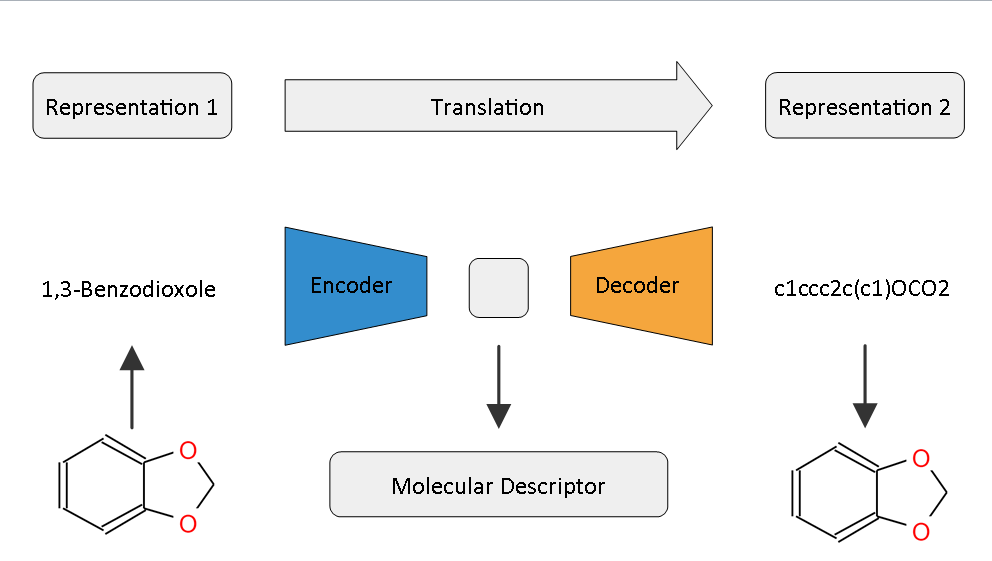

In [6]:
inference_model = InferenceModel()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument in

In [16]:
# X1 -> molecular representation in 512 vector
X1 = inference_model.seq_to_emb(df['smiles_preprocessed'])

INFO:tensorflow:Restoring parameters from /Users/ty/opt/anaconda3/lib/python3.7/site-packages/cddd/data/default_model/model.ckpt


In [17]:
# X2 -> physicochemical descriptors
# Standard and MinMaxScaler for Physicochemical Descriptors

scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

X2 = scaler.fit_transform(df.iloc[:,35:])

In [18]:
# Y -> Binary label for myelosuppressive agents
Y = np.array(df['label'])

In [19]:
print(X1.shape, X2.shape, Y.shape)

(9980, 512) (9980, 1046) (9980,)


In [20]:
X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(X1, X2, Y, test_size = 0.3)
print(np.unique(Y_train, return_counts = True))
print(np.unique(Y_test, return_counts = True))

(array([0, 1]), array([6849,  137]))
(array([0, 1]), array([2939,   55]))


In [21]:
import tensorflow as tf
import keras
from keras import losses
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers import LeakyReLU, Dropout

from keras.layers import Input, Embedding, Reshape, Concatenate
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.models import load_model

In [22]:
# 1046 descriptors and 512 latent vectors

def Two_CNN(in_shape = 1046, latent_space = 512):
    desc_in = Input(shape = (in_shape,))
    li = Dense(1024)(desc_in) # learns identity function of the input
    li = Dense(24*24*1)(li)
    li = Reshape((24, 24, 1))(li)
    
    in_vector = Input(shape = (latent_space,))
    in_expand = Dense(24*24*1)(in_vector)
    in_expand = Reshape((24, 24, 1))(in_expand)
    
    merge = Concatenate()([li, in_expand])
    
    fw = Conv2D(128, (2,2), strides = (2,2), padding = 'same')(merge)
    fw = LeakyReLU(alpha = 0.2)(fw)
    
    fw = Conv2D(128, (2,2), strides = (2,2), padding = 'same')(fw)
    fw = LeakyReLU(alpha = 0.2)(fw)
    fw = MaxPooling2D(pool_size = (2,2))(fw)
    
    fw = Flatten()(fw)
    fw = Dropout(0.4)(fw)
    
    out_layer = Dense(1, activation = 'sigmoid')(fw)
    model = Model(inputs = [desc_in, in_vector], outputs = out_layer)
    opt = Adam(lr = 0.000002)#, beta_1 = 0.5)
    model.compile(loss='mse', optimizer = opt, metrics = ['accuracy']) #'binary_crossentropy'
    
    return model

#keras.backend.clear_session()
DL = Two_CNN()
history = DL.fit(x = [X2_train, X1_train], y = Y_train, batch_size = 64, epochs = 50,
                validation_data = ([X2_test, X1_test], Y_test))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Train on 6986 samples, validate on 2994 samples
Epoch 1/50




6986/6986 [==============================] - 5s 658us/step - loss: 0.2414 - acc: 0.5892 - val_loss: 0.2162 - val_acc: 0.8697
Epoch 2/50
6986/6986 [==============================] - 5s 646us/step - loss: 0.1947 - acc: 0.8762 - val_loss: 0.1747 - val_acc: 0.9696
Epoch 3/50
6986/6986 [==============================] - 5s 649us/step - loss: 0.1575 - acc: 0.9563 - val_loss: 0.1411 - val_acc: 0.9803
Epoch 4/50
6986/6986 [==============================] - 4s 642us/step - loss: 0.1287 - acc: 0.9747 - val_loss: 0.1153 - val_acc: 0.9816
Epoch 5/50
6986/6986 [==============================] - 4s 608us/step - loss: 0.1062 - acc: 0.9795 - val_loss: 0.0960 - val_acc: 0.9816
Epoch 6/50
6986/6986 [==============================] - 4s 588us/step - loss: 0.0894 - acc: 0.9801 - val_loss: 0.0816 - val_acc: 0.9816
Epoch 7/50
6

6986/6986 [==============================] - 5s 675us/step - loss: 0.0203 - acc: 0.9804 - val_loss: 0.0192 - val_acc: 0.9816
Epoch 45/50
6986/6986 [==============================] - 4s 615us/step - loss: 0.0202 - acc: 0.9804 - val_loss: 0.0191 - val_acc: 0.9816
Epoch 46/50
6986/6986 [==============================] - 5s 648us/step - loss: 0.0201 - acc: 0.9804 - val_loss: 0.0190 - val_acc: 0.9816
Epoch 47/50
6986/6986 [==============================] - 4s 634us/step - loss: 0.0200 - acc: 0.9804 - val_loss: 0.0189 - val_acc: 0.9816
Epoch 48/50
6986/6986 [==============================] - 5s 654us/step - loss: 0.0199 - acc: 0.9804 - val_loss: 0.0187 - val_acc: 0.9816
Epoch 49/50
6986/6986 [==============================] - 4s 599us/step - loss: 0.0198 - acc: 0.9804 - val_loss: 0.0185 - val_acc: 0.9816
Epoch 50/50
6986/6986 [==============================] - 5s 654us/step - loss: 0.0196 - acc: 0.9804 - val_loss: 0.0183 - val_acc: 0.9816


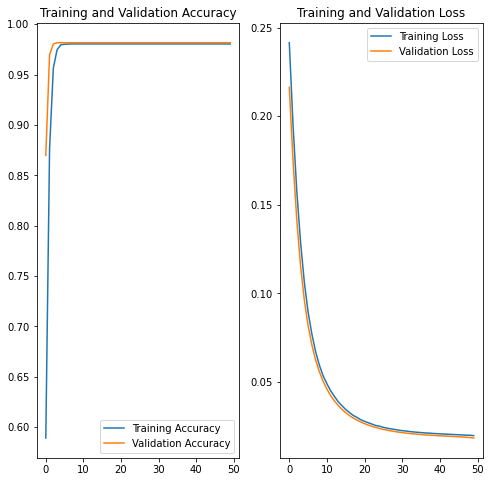

Accuracy: 0.98 Validation accuracy: 0.982


In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('Accuracy:', np.round(acc[-1],3), 'Validation accuracy:', np.round(val_acc[-1], 3))

In [24]:
# Something is not right in above model (too high accuracy), must be normalisation problem in 1046 descriptor space
# Take different approach to normalise descriptor values§

#scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)) # same range as the values from latent vectors

X2 = scaler.fit_transform(df.iloc[:,35:])

In [25]:
X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(X1, X2, Y, test_size = 0.3)
print(np.unique(Y_train, return_counts = True))
print(np.unique(Y_test, return_counts = True))

(array([0, 1]), array([6843,  143]))
(array([0, 1]), array([2945,   49]))


In [26]:
keras.backend.clear_session()
DL = Two_CNN()
history = DL.fit(x = [X2_train, X1_train], y = Y_train, batch_size = 64, epochs = 50,
                validation_data = ([X2_test, X1_test], Y_test))

Train on 6986 samples, validate on 2994 samples
Epoch 1/50
6986/6986 [==============================] - 5s 647us/step - loss: 0.1030 - acc: 0.9795 - val_loss: 0.0632 - val_acc: 0.9836
Epoch 2/50
6986/6986 [==============================] - 4s 569us/step - loss: 0.0494 - acc: 0.9795 - val_loss: 0.0335 - val_acc: 0.9836
Epoch 3/50
6986/6986 [==============================] - 4s 602us/step - loss: 0.0317 - acc: 0.9795 - val_loss: 0.0238 - val_acc: 0.9836
Epoch 4/50
6986/6986 [==============================] - 4s 569us/step - loss: 0.0254 - acc: 0.9795 - val_loss: 0.0201 - val_acc: 0.9836
Epoch 5/50
6986/6986 [==============================] - 4s 595us/step - loss: 0.0229 - acc: 0.9795 - val_loss: 0.0184 - val_acc: 0.9836
Epoch 6/50
6986/6986 [==============================] - 4s 621us/step - loss: 0.0216 - acc: 0.9795 - val_loss: 0.0175 - val_acc: 0.9836
Epoch 7/50
6986/6986 [==============================] - 4s 601us/step - loss: 0.0210 - acc: 0.9795 - val_loss: 0.0170 - val_acc: 0.9836


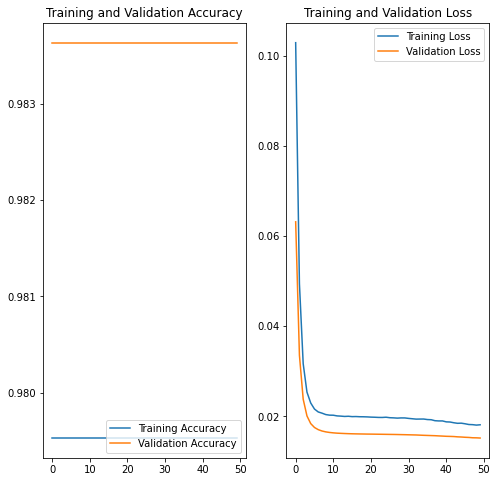

Accuracy: 0.98 Validation accuracy: 0.984


In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('Accuracy:', np.round(acc[-1],3), 'Validation accuracy:', np.round(val_acc[-1], 3))

In [28]:
## Also very high score, below I ran simpler model with only latent vector representation of molecules

In [29]:
X1_train, X1_test, Y_train, Y_test = train_test_split(X1, Y, test_size = 0.3)
print(np.unique(Y_train, return_counts = True))
print(np.unique(Y_test, return_counts = True))

(array([0, 1]), array([6863,  123]))
(array([0, 1]), array([2925,   69]))


In [30]:
def DNN(latent_space = 512):

    in_vector = Input(shape = (latent_space,))
    fw = Dense(1024)(in_vector)
    fw = Dense(512)(fw)
    fw = Dense(256)(fw)
    fw = Dense(128)(fw)
    fw = Dense(64)(fw)
    fw = Dense(32)(fw)
    fw = Dropout(0.4)(fw)

    
    out_layer = Dense(1, activation = 'sigmoid')(fw)
    model = Model(inputs = [in_vector], outputs = out_layer)
    opt = Adam(lr = 0.000002)#, beta_1 = 0.5)
    model.compile(loss='mse', optimizer = opt, metrics = ['accuracy']) #'binary_crossentropy'
    
    return model

In [31]:
keras.backend.clear_session()
DL = DNN()
history = DL.fit(x = [X1_train], y = Y_train, batch_size = 64, epochs = 30,
                validation_data = ([X1_test], Y_test))

Train on 6986 samples, validate on 2994 samples
Epoch 1/30
6986/6986 [==============================] - 2s 354us/step - loss: 0.1693 - acc: 0.7508 - val_loss: 0.0473 - val_acc: 0.9552
Epoch 2/30
6986/6986 [==============================] - 2s 284us/step - loss: 0.0458 - acc: 0.9528 - val_loss: 0.0273 - val_acc: 0.9756
Epoch 3/30
6986/6986 [==============================] - 2s 293us/step - loss: 0.0275 - acc: 0.9751 - val_loss: 0.0244 - val_acc: 0.9766
Epoch 4/30
6986/6986 [==============================] - 2s 270us/step - loss: 0.0231 - acc: 0.9791 - val_loss: 0.0235 - val_acc: 0.9766
Epoch 5/30
6986/6986 [==============================] - 2s 289us/step - loss: 0.0211 - acc: 0.9805 - val_loss: 0.0232 - val_acc: 0.9766
Epoch 6/30
6986/6986 [==============================] - 2s 289us/step - loss: 0.0199 - acc: 0.9815 - val_loss: 0.0230 - val_acc: 0.9766
Epoch 7/30
6986/6986 [==============================] - 2s 330us/step - loss: 0.0194 - acc: 0.9815 - val_loss: 0.0229 - val_acc: 0.9770


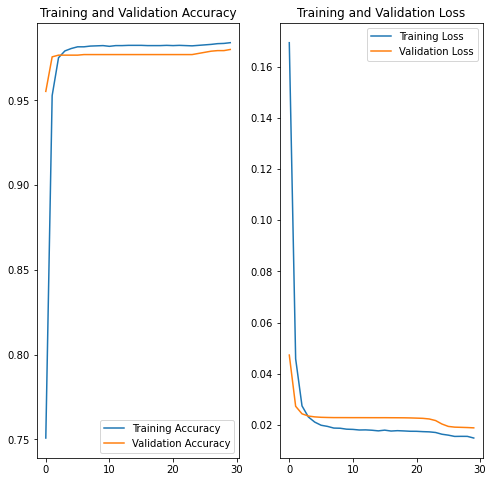

Accuracy: 0.984 Validation accuracy: 0.98


In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('Accuracy:', np.round(acc[-1],3), 'Validation accuracy:', np.round(val_acc[-1], 3))

# Comparison to Traditional ML methods

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as mx

In [37]:
def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    np.set_printoptions(precision=2)
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)
    
class Result:
    def __init__(self, cmat):
        self.cmat = cmat
        self.acc, self.prec, self.rec, self.spec, self.fpr, self.f1 = modelPerformance(cmat)
        #self.impVar = impVar

In [35]:
randomSeed = 300
nIter = 50

In [38]:
# Ridge Logistic Regression
cmat = np.zeros((2, 2), dtype=int)
for k in range(0, nIter):
    mdl = LogisticRegression(penalty='l2',random_state=(randomSeed-k),solver='liblinear').fit(X1_train, Y_train)
    Y_test_hat = mdl.predict(X1_test)
    cmat += mx.confusion_matrix(Y_test, Y_test_hat)
result_RR = Result(cmat)

## Random Forest
mdl = RandomForestClassifier(n_estimators=nIter, criterion='gini', random_state=randomSeed)
mdl = mdl.fit(X1_train, Y_train)
Y_test_hat = mdl.predict(X1_test)
cmat = mx.confusion_matrix(Y_test, Y_test_hat)
result_RF = Result(cmat)

## Linear SVM
mdl = SVC(kernel='linear',C=1)
mdl.fit(X1_train, Y_train)
Y_test_hat = mdl.predict(X1_test)
cmat = mx.confusion_matrix(Y_test, Y_test_hat)
result_linearSVM = Result(cmat)

## Non-linear SVM
mdl = SVC(kernel='rbf',C=1,gamma='scale')
mdl.fit(X1_train, Y_train)
Y_test_hat = mdl.predict(X1_test)
cmat = mx.confusion_matrix(Y_test, Y_test_hat)
result_nonlinearSVM = Result(cmat)

## Gradient Boosted Decision Tree
mdl = GradientBoostingClassifier(n_estimators=nIter, learning_rate=1.0, max_depth=1, random_state=(randomSeed-1))
mdl.fit(X1_train, Y_train)
Y_test_hat = mdl.predict(X1_test)
cmat = mx.confusion_matrix(Y_test, Y_test_hat)
result_GBDT = Result(cmat)

In [39]:
print('Accuracy scores:')
print("Ridge: " "%.3f" % result_RR.acc)
print("linear SVM: " "%.3f" % result_linearSVM.acc)
print("Non-linear SVM: " "%.3f" % result_nonlinearSVM.acc)
print("Random Forest: " "%.3f" % result_RF.acc)
print("GBDT: " "%.3f" % result_GBDT.acc)

Accuracy scores:
Ridge: 0.977
linear SVM: 0.973
Non-linear SVM: 0.980
Random Forest: 0.979
GBDT: 0.962


In [40]:
print('F1-scores:')
print("Ridge: " "%.4f" % result_RR.f1)
print("linear SVM: " "%.4f" % result_linearSVM.f1)
print("Non-linear SVM: " "%.4f" % result_nonlinearSVM.f1)
print("Random Forest: " "%.4f" % result_RF.f1)
print("GBDT: " "%.4f" % result_GBDT.f1)

F1-scores:
Ridge: 0.3030
linear SVM: 0.3220
Non-linear SVM: 0.2716
Random Forest: 0.2025
GBDT: 0.2313


# Visualisation of 192 myelosuppressive agents

In [41]:
df['mols'] = df[df['label'] == 1].smiles_preprocessed.apply(lambda x:Chem.MolFromSmiles(x))

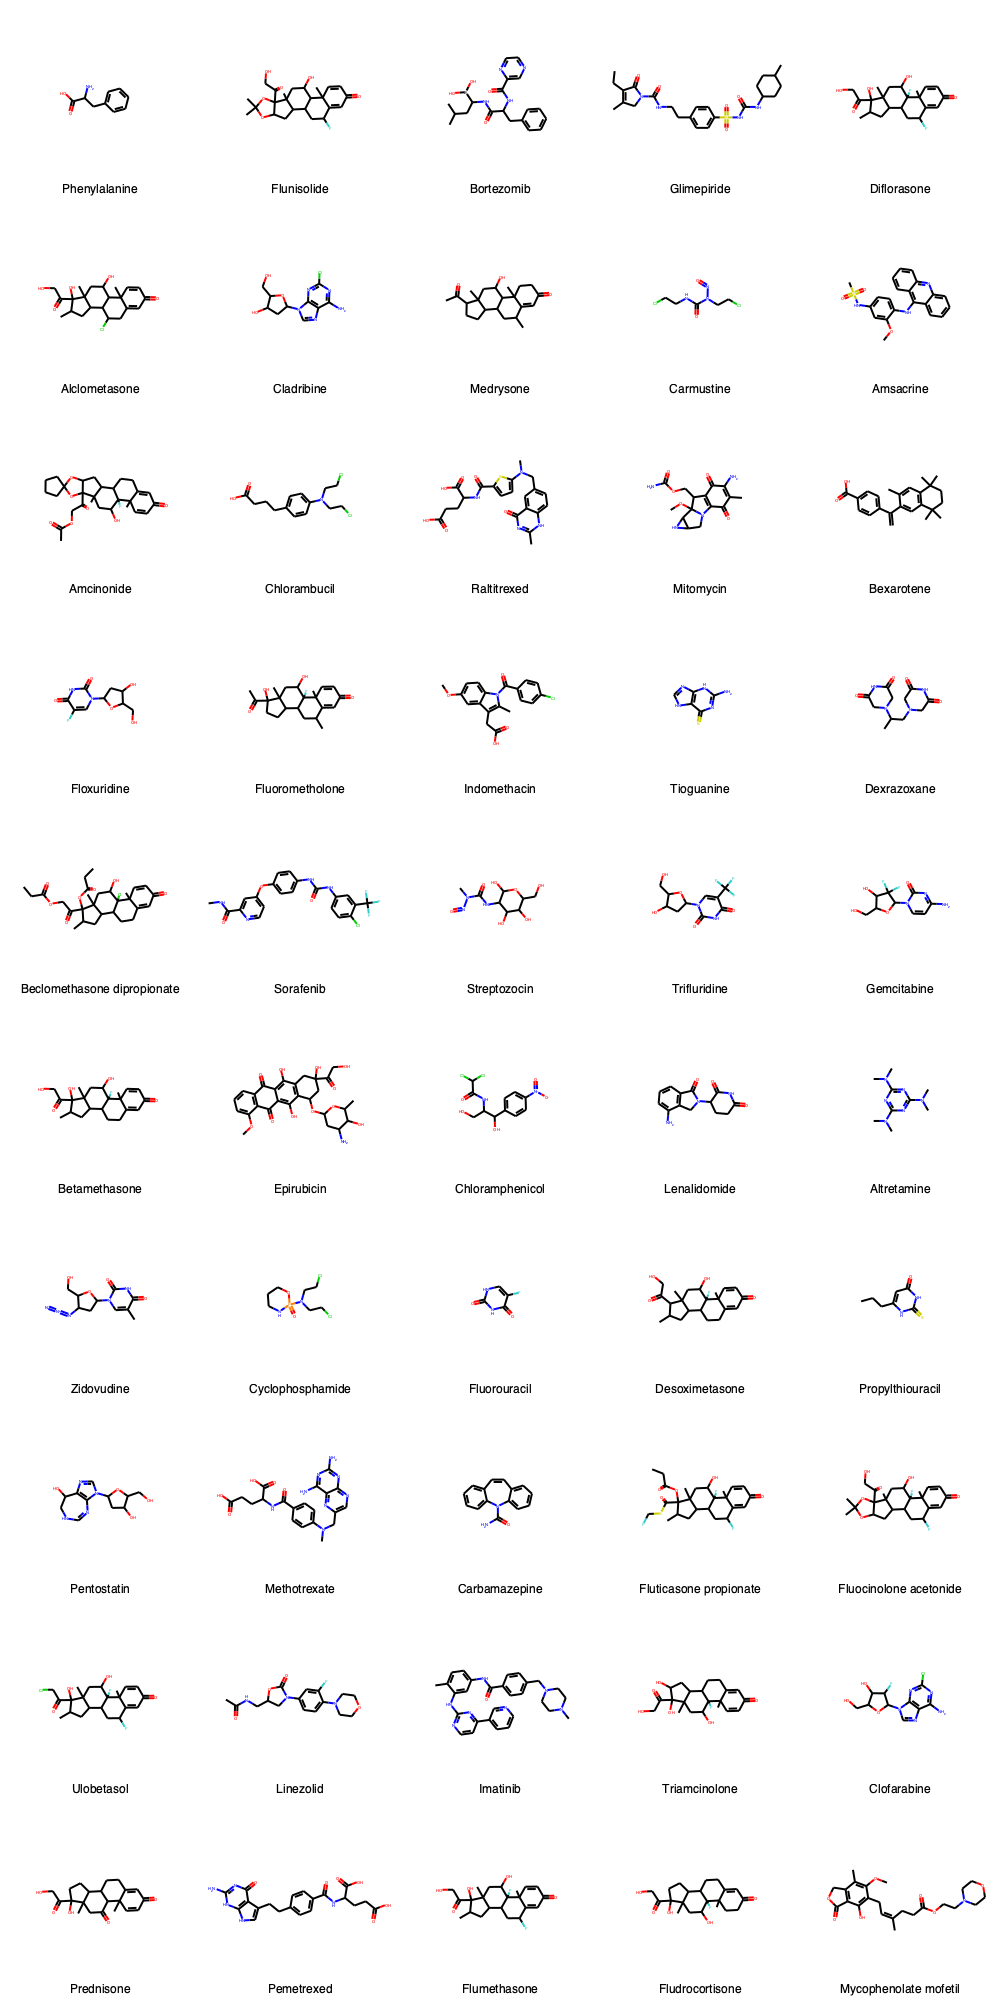

In [42]:
Draw.MolsToGridImage(mols = df['mols'][:50],
                     legends = df['name'].to_list(),
                     molsPerRow = 5
)

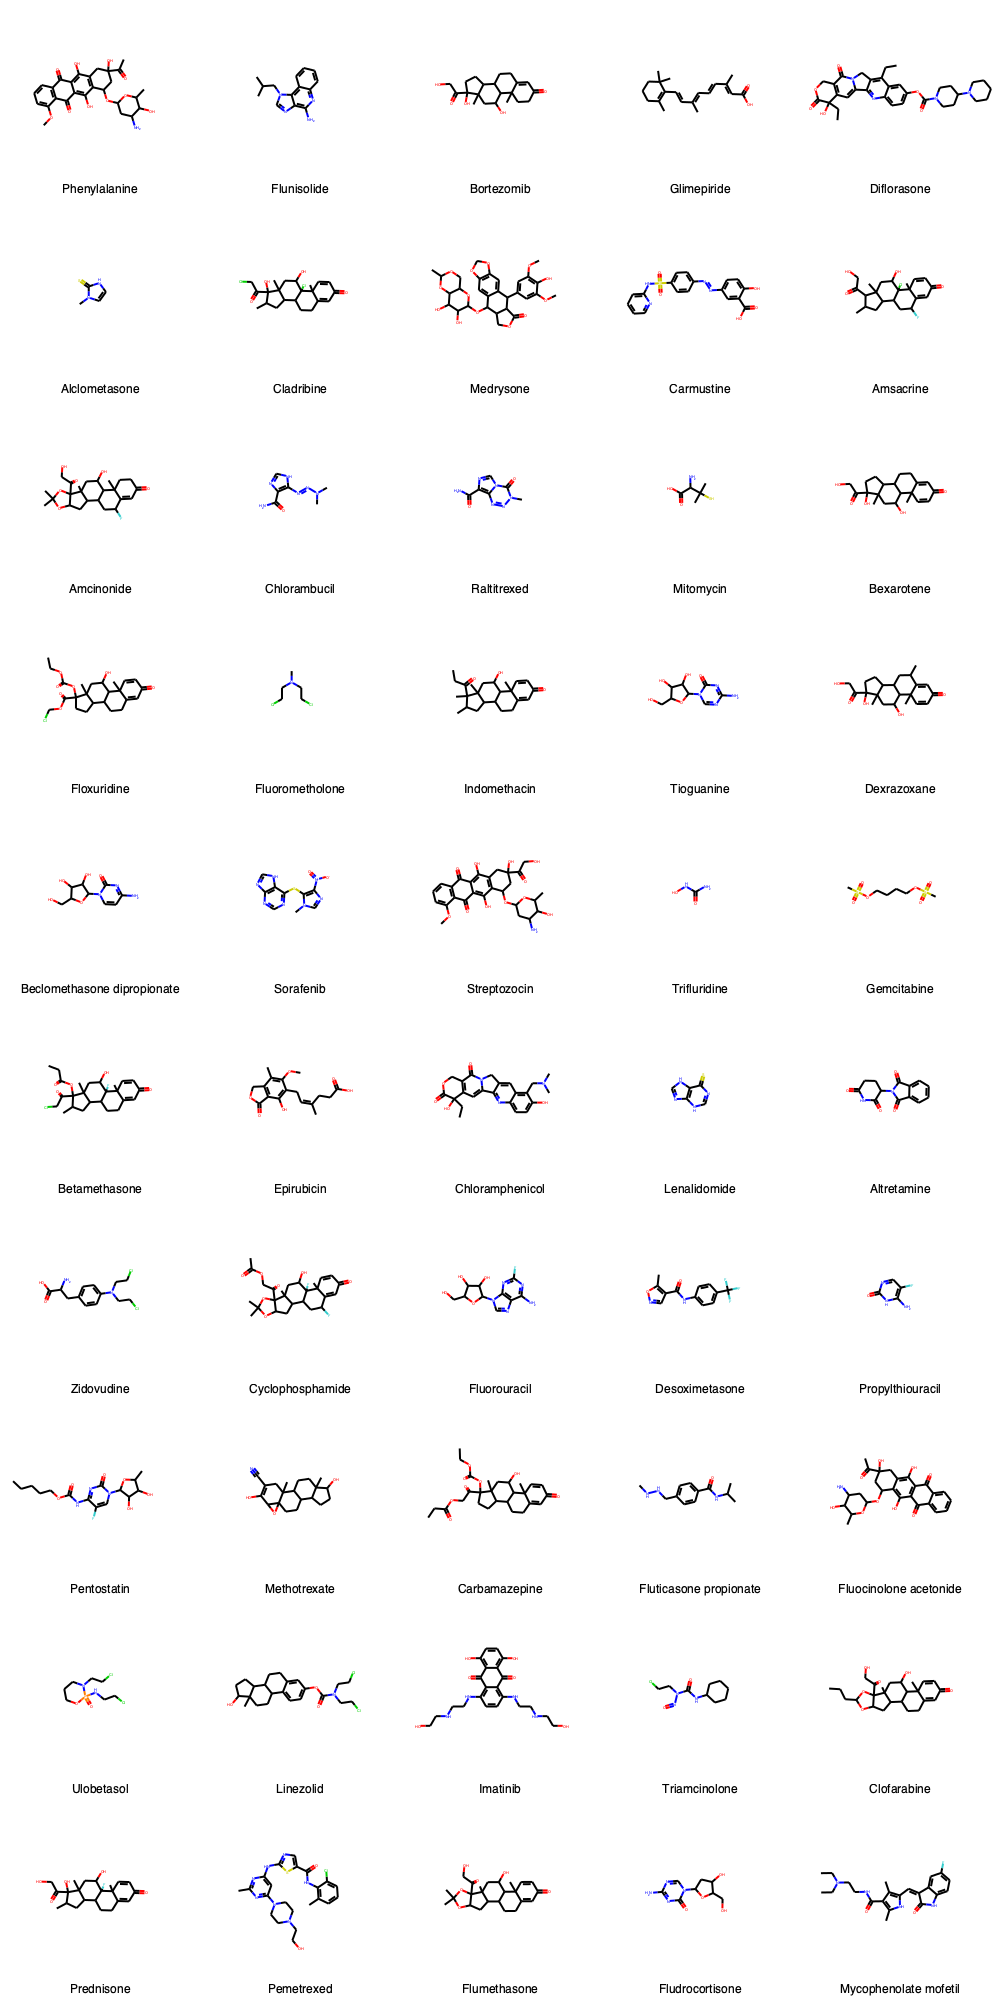

In [43]:
Draw.MolsToGridImage(mols = df['mols'][50:100],
                     legends = df['name'].to_list(),
                     molsPerRow = 5
)

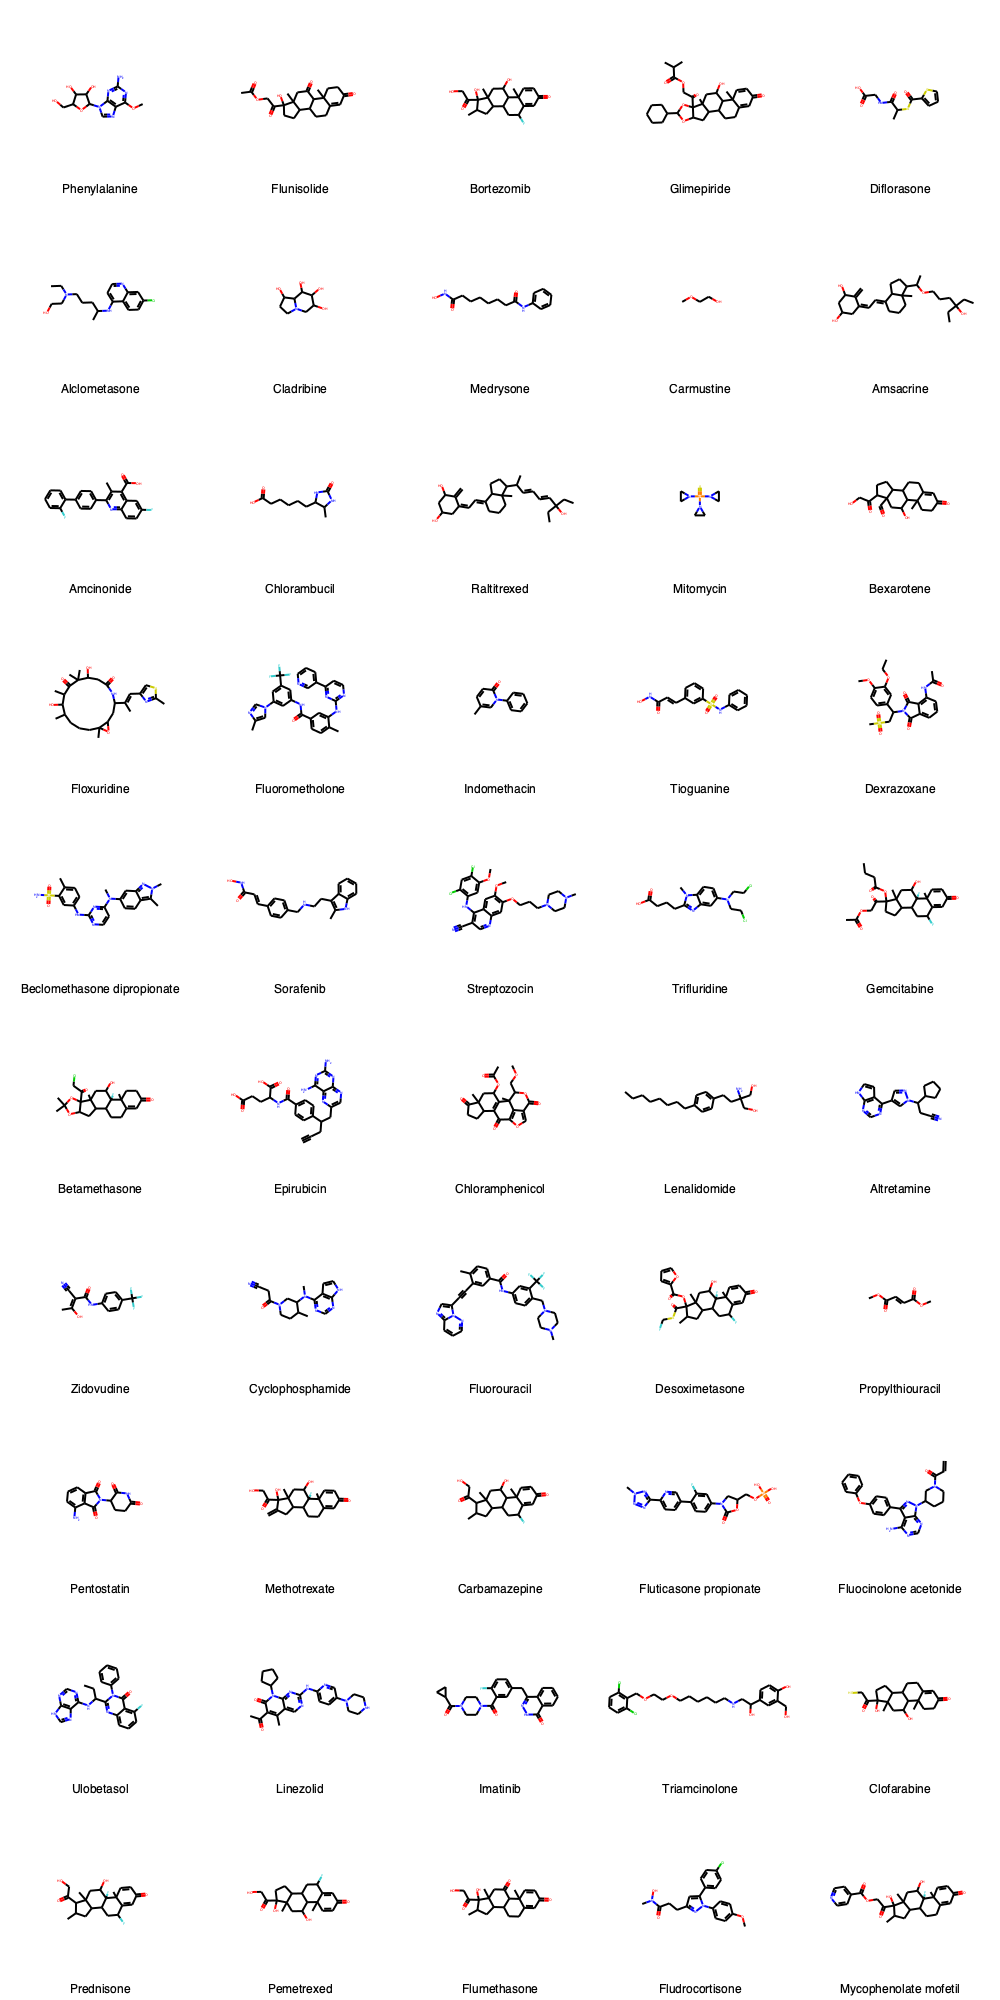

In [44]:
Draw.MolsToGridImage(mols = df['mols'][100:150],
                     legends = df['name'].to_list(),
                     molsPerRow = 5
)

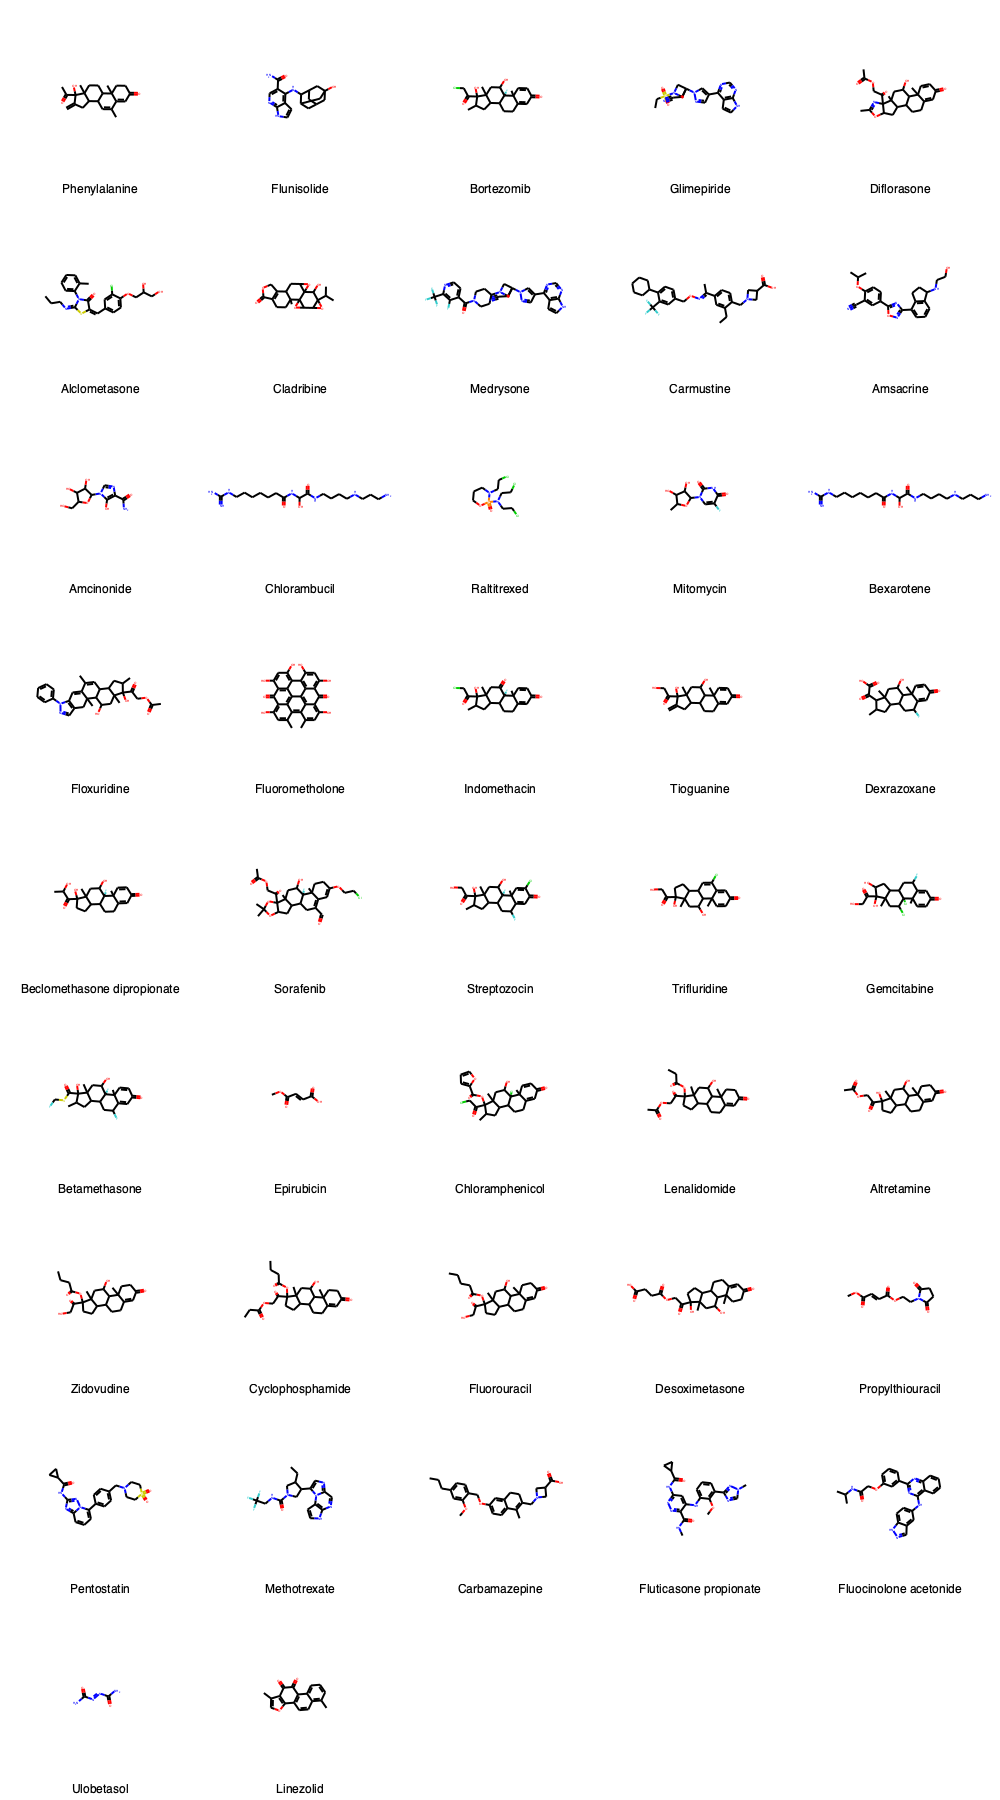

In [45]:
Draw.MolsToGridImage(mols = df['mols'][150:192],
                     legends = df['name'].to_list(),
                     molsPerRow = 5
)

In [53]:
## Some of above molecules are irrelavant from drug-induced myelosuppression such as prednisone
## These are labelled as myelosuppressive agents but not likely to induce neutropenia / anaemia (need input from Carlos)
## Further filter to select molecules of our interest i.e. 'antineoplastic'

df_db[df_db['categories'].str.contains('Immunosuppressive') &
     df_db['type'].str.contains('small molecule') &
     df_db['categories'].str.contains('neoplastic')]

,type,drugbank_id,name,description,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,volume-of-distribution,...,logP,Water_Solubility,Melting_Point,Boiling_Point,Hydrophobicity,Isoelectric_Point,caco2_Permeability,pKa,Radioactivity,aliases
82,small molecule,DB00188,Bortezomib,Bortezomib is a dipeptide boronic acid derivat...,Bortezomib works to target the ubiquitin-prote...,The ubiquitin-proteasome pathway is a homeosta...,The Lowest published toxic dose (TD<sub>Lo</su...,"Bortezomib is primarily metabolized by CYP3A4,...",Following intravenous administration of 1 mg/m...,The mean distribution volume of bortezomib ran...,...,None,None,None,None,None,None,None,None,None,Bortezomib|Bortezomib Accord|Bortezomib Fresen...
136,small molecule,DB00242,Cladribine,An antineoplastic agent used in the treatment ...,Cladribine is a synthetic purine nucleoside th...,Cladribine is structurally related to fludarab...,Symptoms of overdose include irreversible neur...,Metabolized in all cells with deoxycytidine ki...,Oral bioavailability is 34 to 48%.,* 4.5 ± 2.8 L/kg [patients with hematologic ma...,...,None,None,None,None,None,None,None,None,None,\n |Cladribine|Cladribine Injection|Leust...
156,small molecule,DB00262,Carmustine,A cell-cycle phase nonspecific alkylating anti...,Carmustine is one of the nitrosoureas indicate...,"Carmustine causes cross-links in DNA and RNA, ...",The oral LD<sub>50</sub>s in rat and mouse are...,Hepatic and rapid with active metabolites. Met...,5 to 28% bioavailability,,...,None,None,None,None,None,None,None,None,None,\n |BiCNU|Bicnu|Carmustine|Carmustine Obv...
170,small molecule,DB00276,Amsacrine,Aminoacridine derivative that is a potent inte...,Amsacrine is an aminoacridine derivative that ...,Amsacrine binds to DNA through intercalation a...,Symptoms of overdose include nausea and vomiti...,"Extensive, primarily hepatic, converted to glu...",Poorly absorbed,,...,None,None,None,None,None,None,None,None,None,\n |Amsa Pd|Amsacrine
183,small molecule,DB00290,Bleomycin,A complex of related glycopeptide antibiotics ...,Bleomycin is an antibiotic which has been show...,Although the exact mechanism of action of bleo...,"Excessive exposure may cause fever, chills, na...",Hepatic,Systemic absorption is approximately 45%.,,...,None,None,None,None,None,None,None,None,None,Blenoxane|Blenoxane Pws 15unit|Bleomycin|Bleom...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333,small molecule,DB14845,Filgotinib,"Rheumatoid arthritis (RA) is a chronic, autoim...",In addition to targeted Janus kinase (JAK) 1 i...,There are four Janus kinase (JAK) enzymes incl...,Toxicity information regarding filgotinib is n...,Carboxylesterase enzymes are involved in the m...,Filgotinib is rapidly absorbed after oral admi...,,...,None,None,None,None,None,None,None,None,None,Filgotinib|Jyseleca
10482,small molecule,DB15091,Upadacitinib,Upadacitinib is an oral Janus kinase (JAK)1-se...,Upadacitinib is a DMARD that works by inhibiti...,Rheumatoid arthritis (RA) is a chronic autoimm...,There is limited clinical information on the o...,Upadacitinib predominantly undergoes CYP3A4-me...,Upadacitinib displays a dose-proportional phar...,The volume of distribution of upadacitinib in ...,...,None,None,None,None,None,None,None,None,None,Rinvoq|Upadacitinib
11263,small molecule,DB16650,Deucravacitinib,Deucravacitinib is a novel oral selective tyro...,Deucravacitinib is a tyrosine kinase 2 (TYK2) ...,Tyrosine kinase 2 (TYK2) is a member of the Ja...,No information regarding the acute toxicity pr...,Deucravacitinib undergoes N-demethylation medi...,"Following oral administration, deucravacitinib...",The volume of distribution of deucravacitinib ...,...,None,None,None,None,None,None,None,None,None,Deucravacitinib|Sotyktu
11275,small molecule,DB16703,Belumosudil,Belumosudil is used in the treatment of chroni...,Belumosudil appears to inhibit several pro-fib...,Chronic graft-versus-host disease (GVHD

# Validation of CDDD (latent vector encoder-decoder) method

In [7]:
np.array(df['smiles_preprocessed'])

array(['NC(Cc1ccccc1)C(=O)O',
       'CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(C)C2(C(=O)CO)O1',
       'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O', ...,
       'Cc1cc2c(C(C)C)c(O)c(O)c(C=O)c2c(O)c1-c1c(C)cc2c(C(C)C)c(O)c(O)c(C=O)c2c1O',
       'CN1CCN(Cc2ccc(NC(=O)c3n[nH]cc3Nc3ncnc4[nH]ccc34)cc2)CC1',
       'Cc1[nH]nc2c1N=C(c1ccccc1Cl)c1cnc(N3CCOCC3)cc1N2'], dtype=object)

In [10]:
keras.backend.clear_session()

original_smiles = np.array(df['smiles_preprocessed'])
X_latent = inference_model.seq_to_emb(df['smiles_preprocessed'])
reconstructed_smiles = inference_model.emb_to_seq(X_latent)



INFO:tensorflow:Restoring parameters from /Users/ty/opt/anaconda3/lib/python3.7/site-packages/cddd/data/default_model/model.ckpt
INFO:tensorflow:Restoring parameters from /Users/ty/opt/anaconda3/lib/python3.7/site-packages/cddd/data/default_model/model.ckpt


In [11]:
print(len(original_smiles), len(set(original_smiles) & set(reconstructed_smiles)))
matching_smiles = len(set(original_smiles) & set(reconstructed_smiles))

9980 9292


In [15]:
print('reconstruction percentage back to exact SMILE strings is:',np.round(matching_smiles/len(original_smiles)*100,3),'%')
print('this number will be higher if I run similarity searching algorithm between the two groups as a single molecule can have more than one SMILE representation')

reconstruction percentage back to exact SMILE strings is: 93.106 %
this number will be higher if I run similarity searching algorithm between the two groups as a single molecule can have more than one SMILE representation
